***
# Lab 3 ML7331
> ### By Allen Hoskins, Brittany Lewandowski, Alexy Morris, Fidel Tamares


***
 

# Business Understanding 1

>For this lab, the team used a data set from Kaggle named: “2015 Flight Delays and Cancellations.” The data set contains 3 spreadsheets containing airport, airline, and flight information. The purpose of the data set is to provide consumers with information about the quality of services provided to them by airlines. Several attributes contained in the data set include: flight numbers, scheduled departure, departure delay, flight cancellations, and time spent in the air. For a full list of attributes in the data set, as well as their data types, please visit this site. 

>This data set is meaningful as it contains decision criteria that customers evaluate when determining which airline to fly with. For example, if a customer knows that a specific airline has the most cancellations, they are likely to not fly with that airline. Similarly, if a customer knows that the overall experience provided by a specific airline is poor, they will not fly with them. Additionally, this data set is meaningful to airlines because they can use the data to identify factors that are contributing to flight delays. After identifying the factors that are influencing delays, airlines can make modifications to their operations to minimize future delays.  

##For this lab, the team chose to predict flight delays and flight departure delays. To predict delays, the team created a binary attribute named `is_delay`. Seeing that the departure delay attribute is continuous, the team will predict this outcome as a regression problem. The team will evaluate the effectiveness of the regression algorithm with tenfold cross validation and by the model’s, R^2, MSE. Conversely the `is_delay` attribute is categorical and will be evaluated as classification problem. The team will evaluate the effectiveness of the classification algorithm using tenfold cross validation, model accuracy and AUC. 

### The team will know that they have mined useful knowledge from the data set if they are able to: 
 1. Identify related attributes and trends that exist in the data set.  
 2. Determine which variables are correlated with one another.   
 3. Create a prediction algorithm for the attributes: `departure_delay` and `is_delay`, using the effectiveness metrics of R^2 and MSE for `departure_delay` and model accuracy and AUC for `is_delay` to evaluate model performance. 
 
### The team has chosen the following validation methods to access our models: 
***

# Data Understanding 1

## Curating Data Sets

> In this section, the team merged the three files from Kaggle to create a curated data set that was used during this lab. The three files included flight information, airport information and airline information.

In [7]:
#import packages
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_predict
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,  silhouette_score
from sklearn.metrics.cluster import rand_score, adjusted_rand_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import time
import warnings

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
#remove warnings after verifying code
warnings.filterwarnings("ignore")

df_flights = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/flights.csv',low_memory = False)

df_airports = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airports.csv',low_memory = False)

df_airlines = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airlines.csv',low_memory = False)

pd.set_option('display.max_columns', None)

df_airports.head()

df_flights.head()

df_airlines.head()

#merge flight and airline information
df_merge_airline = df_flights.merge(df_airlines, left_on = 'AIRLINE', right_on = 'IATA_CODE',how='left')
df_merge_airline.head()

#find airports with missing LATITUDE
df_airports[df_airports['LATITUDE'].isna() == True]

#impute missing lat/long values from:https://www.airnav.com/airport/
#ECP:
>    lat:30.3582408
    long:-85.7956022
 PGB
    lat:44.6509444
    long:-73.4681389
#UST:
    lat:29.9592503
    long:-81.3397292

lat_inpute = {
    'ECP': 30.3582408,
    'PBG': 44.6509444,
    'UST': 29.9592503
}
long_inpute = {
    'ECP': -85.7956022,
    'PBG': -73.4681389,
    'UST': -81.3397292
}
#missing airport lat/long IATA CODE

missing_lat_long = ['ECP','PBG','UST']

df_airports['LATITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(lat_inpute)
df_airports['LONGITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(long_inpute)

#merge origin airport information to merged data 
df_merge_origin = df_merge_airline.merge(df_airports, left_on = 'ORIGIN_AIRPORT',right_on = 'IATA_CODE', how='left')

rename_dict_origin =  {'CITY':'CITY_ORIGIN',
                'STATE':'STATE_ORIGIN',
                'COUNTRY':'COUNTRY_ORIGIN',
                'LATITUDE':'LATITUDE_ORIGIN',
                'LONGITUDE':'LONGITUDE_ORIGIN'}
df_merge_origin.rename(columns=rename_dict_origin,inplace = True)

#merge destination airport information to dataset
df_merge_final = df_merge_origin.merge(df_airports,left_on = 'DESTINATION_AIRPORT',right_on = 'IATA_CODE',how='left')

rename_dict_dest =  {'CITY':'CITY_DESTINATION',
                'STATE':'STATE_DESTINATION',
                'COUNTRY':'COUNTRY_DESTINATION',
                'LATITUDE':'LATITUDE_DESTINATION',
                'LONGITUDE':'LONGITUDE_DESTINATION'}
df_merge_final.rename(columns=rename_dict_dest,inplace = True)

df_merge_final.columns= df_merge_final.columns.str.strip().str.lower()

df_ordered = df_merge_final.copy(deep=True)

col_order = ['year','month','day','day_of_week','airline_x','airline_y','flight_number','tail_number',
             'origin_airport','airport_x','city_origin','state_origin','country_origin','latitude_origin','longitude_origin',
             'destination_airport','airport_y','city_destination','state_destination','country_destination','latitude_destination','longitude_destination',
             'scheduled_departure','departure_time','departure_delay','taxi_out','wheels_off','scheduled_time','elapsed_time','air_time','distance',
             'wheels_on','taxi_in','scheduled_arrival','arrival_time','arrival_delay','diverted','cancelled','cancellation_reason','air_system_delay',
             'security_delay','airline_delay','late_aircraft_delay','weather_delay']

df_ordered = df_ordered[col_order]

rename_dict_merged =  {'airline_x':'airline_cd',
                       'airline_y':'airline_name',
                       'airport_x': 'airport_origin',
                       'airport_y':'airport_destination'}
df_ordered.rename(columns=rename_dict_merged,inplace = True)

df_ordered.head()

df_ordered.to_csv(r"C:\Users\Alex M\Downloads\airline_merged.csv")

## Data Meaning Type:

> The team used a data set from Kaggle containing attributes about 2015 airline delays. The meaningfulness of the data is to provide both airlines and customers with information relevant to flight delays. This data is useful as it helps customers make decisions about which airline they fly with, and it helps airlines determine what the cause(s) of flight delays are. From a business perspective, knowing this information is critical as it drives an organization’s bottom line.  

> To get better insight into the attributes contained in the data set and their data types, the team ran `df.info(verbose=True,show_counts=True)` in Python. The full output from the command is found in the team’s code, however, 5 takeaways from the output are:  

> **1. The data set contains 5,819,079 entries.**<br> 
> **2. The data set contains 45 columns.**  <br>
> **3. There are 20 columns classified with the data type, float.**<br>
> **4. There are 11 columns classified with the data type, int.** <br>
> **5. There are 14 columns classified with the data type, object.**

> For additional context around attributes in the data set, the team created a data dictionary. The data dictionary contains attribute names, attribute descriptions, and attribute data types and is useful for business understanding. The data dictionary is found below: 

In [ ]:
#reading in data set from merged files
df = pd.read_csv(r"C:\Users\Alex M\Downloads\airline_merged.csv",low_memory=False)

In [ ]:
#removing unwanted column from previous export
df = df.drop(columns = ['Unnamed: 0'])

In [ ]:
df.info(show_counts = True, verbose = True)

> The team ran df.info() to create the data dictionary shown above. df.info() provided the team with column indeces, with column names, and with the data types of each column. This information was useful as it helped the team understand how the computer was reading the variables and it helped the team identify variables whose data types may need to be modified. An example of a data type that the team may modify in future labs is the variable "month". The computer has classified the column as an integer, however since the column only contains variables (1-12), it may be better represented as a categorical variable. Another piece of helpful information df.info() output was the count of how many columns are of the data type float(20), integer(10) and object(14). This information is useful as it gives the team an idea of how much feature manipulation is going to need to be done before modeling can commence. 

#### Below information on data frame columns in table uses:
>`df.info(show_counts = True, verbose = True)` with added attribute description

| Attribute Name | Attribute Description | Non-null Count | Attribute Data Type|
| :--- | :--- | :---| :---|
| year | Year data was collected |5819079|int |
| month | Month data was collected |5819079| int |
| day | Day data was collected (1-25) |5819079| int |
| day_of_week | Day of the week data was collected (1-7) |5819079|int |
| airline_name | Name of airline ex) Alaska Airlines Inc. |5819079| object |
| airline_cd | Code for airline ex) AA |5819079|object |
| flight_number | Unique identifier for each flight |5804358| int |
| tail_number  | Unique identifier for a plane | 5819079|object |
| origin_airport | Code of origin airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_origin | Airport flight originates from ex) San Francisco International Airport  | 5332914|object  |
| city_origin | City the flight came from | 5332914|object |
| state_origin | State the flight came from | 5332914|object |
| country_origin | Country flight came from | 5332914|object |
| latitude_origin | Latitude coordinates the flight came from | 5332914|float |
| longitude_origin | Longitude coordinates the flight came from | 5332914|float |
| destination_airport | Code of destination airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_destination | Name of destination airport ex) Dallas Fort Worth International Airport |5332914|	object |
| city_destination | City of destination | 5332914|object |
| state_destination | State of destination | 5332914|object |
| country_destination | Country of destination |5332914| object |
| latitude_destination | Latitude coordinates of flight destination | 5332914|float |
| longitude_destination | Longitude coordinates of flight destination |5332914| float |
| scheduled_departure | Time of flight departure | 5819079|int |
| departure_time | Time flight departed | 5732926|float |
| departure_delay | Time flights are delayed from departure |5732926| float |
| taxi_out | Time spent taxiing to the runway  |5730032| float |
| wheels_off | Time spent removing wheels  | 5730032|float  |
| scheduled_time | When flight is scheduled to back up from gate | 5819073|float |
| elapsed_time | Calculated column derived by adding taxi & air time together |5714008| float |
| air_time | Time flight spends in the air | 5714008|float |
| distance | Distance traveled by flights | 5819079|int |
| wheels_on | Time spent |5726566| float |
| taxi_in | Time spent taxiing to the gate | 5726566|float |
| scheduled_arrival | Scheduled flight arrival time |5819079| int |
| arrival_time | Time flight actually arrived | 5726566|float |
| arrival_delay |Time flights are delayed from arrival |5714008| float |
| diverted | Binary indicator of if a flight was diverted or not (0,1) |5819079| int |
| cancelled | Binary indicator of if a flight was canceled or not (0,1) |5819079| int |
| cancellation_reason | Reason for flight cancellation | 89884|object |
| air_system_delay | Flight delays due to air systems |1063439| float |
| security_delay | Flight delays due to security issues |1063439| float |
| airline_delay | Flight delays due to an airline specific problem |1063439| float |
| late_aircraft_delay | Flight delays due to an aircraft being late | 5819079|float |
| weather_delay  | Flight delays due to weather | 1063439|float |

***

### Data Quality

> The team's airline data set has a total of 5,819,079 rows and 45 attributes after merging all 3 files from 2015 Flight Delays and Cancellations, a Kaggle data set. Within those 5,819,079 rows, there are 36,299,254 missing values scattered throughout the data set with 0 duplicate records. For the last 6 columns `%delay`, we are not worried about the high number of missing values as they are only present if a flight was delayed for one of those reasons. We will handle those fields later when creating a model.

In [91]:
df.isna().sum().sum()

45400611

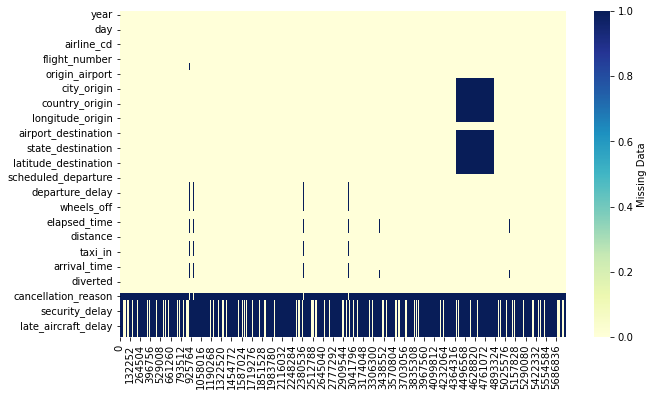

In [29]:
#plotting missing values
# code altered from: https://datavizpyr.com/visualizing-missing-data-with-seaborn-heatmap-and-displot/
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'});

> Our team then examined a breakdown of these missing values and noticed that there was a pattern of missing values. In attributes that seem closely related, we see the same number of missing values repeated several times. An example of this is displayed 11 attributes down with `airport_origin` to `country_origin`; all included attributes have exactly 486,165 missing values. This is due to the difference in the flights data set and airports data set having a different number of airport codes and these records will be removed in the next cell.

> The attribute `cancellation_reason` is composed of the recorded reason for a flight's cancellation; the majority of our records were not cancelled and as such, there were no values in this attribute. From our research, we found that the attribute’s filled rows had one of the following entries: A for Airline/Carrier, B for Weather, C for National Air System, and D for Security. With this data understanding, we decided to impute a 5th option which filled the remaining rows with the value `NC`, representing not cancelled. 

In [30]:
#Removing rows where Origin airport is NaN
df = df[df['airport_origin'].notna()]

In [31]:
df.cancellation_reason = df.cancellation_reason.fillna('NC') 

In [32]:
delay_fillna = ['arrival_delay', 'departure_delay', 'air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'] 
df[delay_fillna] = df[delay_fillna].fillna(0)  

> The last attributes our team addressed are the origin/destination, latitude, and longitude attributes. Our team thought that the missing values for these 2 attributes were particularly weird because of the relatively small difference between the null counts of latitude and longitude and the attribute range starting with `airport_origin`. After sorting the original airport data set by longitude ascending, we discovered that there are 3 airports with missing latitudes and longitudes. As there were only 3 missing coordinates our team found said coordinates, imputed them, and re-ran our merger.   

### Previously run code to impute missing lat/long values 
#### Imputed missing lat/long values from:https://www.airnav.com/airport/

`ECP:`<br>
>   `lat:30.3582408`<br>
>    `long:-85.7956022`<br>

`PGB:`<br>
>    `lat:44.6509444`<br>
>    `long:-73.4681389`<br>

`UST:`<br>
>    `lat:29.9592503`<br>
>    `long:-81.3397292`<br>

`lat_inpute = {`<br>
>    `'ECP': 30.3582408,`<br>
>    `'PBG': 44.6509444,`<br>
>    `'UST': 29.9592503`<br>
` }`<br>

`long_inpute = {`<br>
>    `'ECP': -85.7956022,`<br>
>    `'PBG': -73.4681389,`<br>
>    `'UST': -81.3397292`<br>
`}`<br>


`missing_lat_long = ['ECP','PBG','UST']`<br>

`df_airports['LATITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(lat_inpute)`<br>
`df_airports['LONGITUDE'].loc[df_airports['IATA_CODE'].isin(missing_lat_long)] = df_airports['IATA_CODE'].map(long_inpute)`

#### Remaining Missing Values
> As for the remaining missing values we have decided to drop them. The remaining attributes are a combination of categorical, discrete, and 4 numerical attributes that we have decided are too heavily dependent on other attributes to fill in with a mean or median value. Any other numerical variaible with a missing value will later be imputed with a 0 to signify no delay for that variable.

> Since several rows contain the same route information, because airlines have set routes/schedules, we have decided to regard any rows with similar data as a valid part of our data set.  

#### Duplicate records: 

In [34]:
df[df.duplicated()] 

Empty DataFrame
Columns: [year, month, day, day_of_week, airline_cd, airline_name, flight_number, tail_number, origin_airport, airport_origin, city_origin, state_origin, country_origin, latitude_origin, longitude_origin, destination_airport, airport_destination, city_destination, state_destination, country_destination, latitude_destination, longitude_destination, scheduled_departure, departure_time, departure_delay, taxi_out, wheels_off, scheduled_time, elapsed_time, air_time, distance, wheels_on, taxi_in, scheduled_arrival, arrival_time, arrival_delay, diverted, cancelled, cancellation_reason, air_system_delay, security_delay, airline_delay, late_aircraft_delay, weather_delay]
Index: []

#### Outliers

>  The below boxplots show that our airline data is extremely right skewed. The team will continue to evaluate how to deal with the outliers. The data will need to be transformed before performing any modeling. 

>Several methods of dealing with the outliers within our data currently consist of:

>**1. Keep data as is.**<br>
>**2. Remove any data point that is longer than 360 minutes.**<br>
>**3. Transform data using either a log scale or another scale.**

> If we were to transform the data in any way, we would need to consider intrepretability of the output of models and graphs.

***

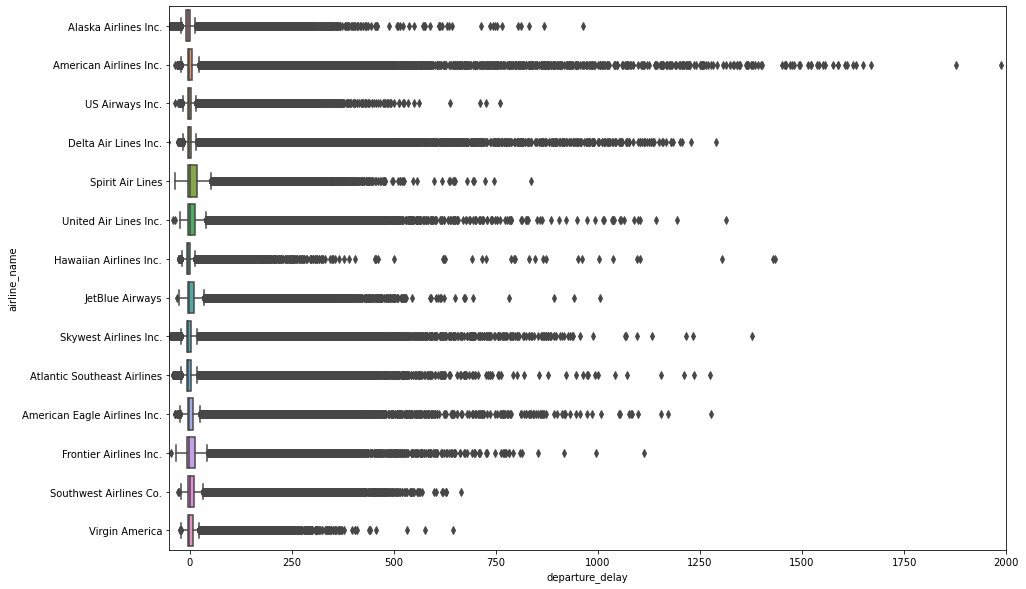

In [35]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="departure_delay",y='airline_name') 
plt.xlim(-50, 2000); 

In [37]:
df_stats.describe()

scheduled_departure  departure_time  departure_delay      taxi_out  \
count         5.332914e+06    5.249100e+06     5.332914e+06  5.246302e+06   
mean          1.330107e+03    1.336074e+03     9.620947e+00  1.610290e+01   
std           4.843130e+02    4.974114e+02     3.731556e+01  8.991109e+00   
min           1.000000e+00    1.000000e+00    -8.200000e+01  1.000000e+00   
25%           9.170000e+02    9.210000e+02    -5.000000e+00  1.100000e+01   
50%           1.325000e+03    1.331000e+03    -1.000000e+00  1.400000e+01   
75%           1.730000e+03    1.741000e+03     7.000000e+00  1.900000e+01   
max           2.359000e+03    2.400000e+03     1.988000e+03  2.250000e+02   

         wheels_off  scheduled_time  elapsed_time      air_time      distance  \
count  5.246302e+06    5.332908e+06  5.231130e+06  5.231130e+06  5.332914e+06   
mean   1.357926e+03    1.417832e+02  1.371940e+02  1.136654e+02  8.228955e+02   
std    4.990460e+02    7.525171e+01  7.430076e+01  7.229764e+01  6.077992e+02   
min    1.000000e+00    1.800000e+01  1.400000e+01  7.000000e+00  2.100000e+01   
25%    9.350000e+02    8.500000e+01  8.200000e+01  6.000000e+01  3.730000e+02   
50%    1.343000e+03    1.230000e+02  1.190000e+02  9.400000e+01  6.490000e+02   
75%    1.755000e+03    1.740000e+02  1.690000e+02  1.440000e+02  1.065000e+03   
max    2.400000e+03    7.180000e+02  7.660000e+02  6.900000e+02  4.983000e+03   

          wheels_on       taxi_in  scheduled_arrival  arrival_time  \
count  5.242972e+06  5.242972e+06       5.332914e+06  5.242972e+06   
mean   1.471021e+03  7.438059e+00       1.493747e+03  1.475922e+03   
std    5.237584e+02  5.686169e+00       5.079263e+02  5.279477e+02   
min    1.000000e+00  1.000000e+00       1.000000e+00  1.000000e+00   
25%    1.054000e+03  4.000000e+00       1.110000e+03  1.058000e+03   
50%    1.508000e+03  6.000000e+00       1.520000e+03  1.512000e+03   
75%    1.912000e+03  9.000000e+00       1.919000e+03  1.917000e+03   
max    2.400000e+03  2.480000e+02       2.400000e+03  2.400000e+03   

       arrival_delay  air_system_delay  security_delay  airline_delay  \
count   5.332914e+06      5.332914e+06    5.332914e+06   5.332914e+06   
mean    4.792651e+00      2.537649e+00    1.461584e-02   3.556582e+00   
std     3.941143e+01      1.326864e+01    9.460972e-01   2.203969e+01   
min    -8.700000e+01      0.000000e+00    0.000000e+00   0.000000e+00   
25%    -1.300000e+01      0.000000e+00    0.000000e+00   0.000000e+00   
50%    -4.000000e+00      0.000000e+00    0.000000e+00   0.000000e+00   
75%     8.000000e+00      0.000000e+00    0.000000e+00   0.000000e+00   
max     1.971000e+03      1.134000e+03    5.730000e+02   1.971000e+03   

       late_aircraft_delay  weather_delay  
count         5.332914e+06   5.332914e+06  
mean          4.456789e+00   5.608581e-01  
std           2.094994e+01   9.019633e+00  
min           0.000000e+00   0.000000e+00  
25%           0.000000e+00   0.000000e+00  
50%           0.000000e+00   0.000000e+00  
75%           0.000000e+00   0.000000e+00  
max           1.331000e+03   1.211000e+03

## df.describe:

>After running df.describe(), the team was able to identify variables that contain outliers. One example of this is our taxi_in variable. The mean for taxi_in is 7.438059e+00 while the max is 2.480000e+02. This indicates a large disparity. This disparity was also shown in other columns. When thinking about removing outliers such as this, the team recognizes that the mean will change for each variable. This is something we will continue to consider. 

***

# Data Understanding 2

>One of the attributes the team was interested in visualizing was the numeric response variable, `departure_delay`. The team wanted to look at the distribution of the variable to determine if it was uniform or not. To complete this, the team created a histogram for `departure_delay`. A histogram was chosen as an appropriate visualization as they visually communicate an attribute’s distribution.  

>As evidence below, the distribution of `departure_delay` proved to be right skewed. Knowing that having skewed variables in a model negatively impacts results, (skewed variables don’t meet statistical assumptions for regression), the team log transformed `departure_delay` to see if the distribution was corrected. After log transforming the response, the variable’s distribution was uniform.  

#### Histogram of Departure Delays

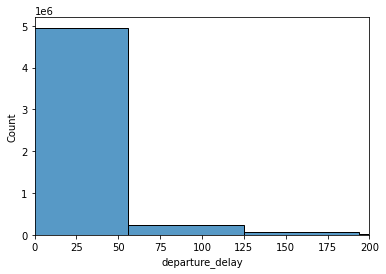

In [40]:
#Creating a histogram of the departure_delay variable. The variable is right skewed.

sns.histplot(data=df, x="departure_delay", bins=30) 
plt.xlim(0, 200); 

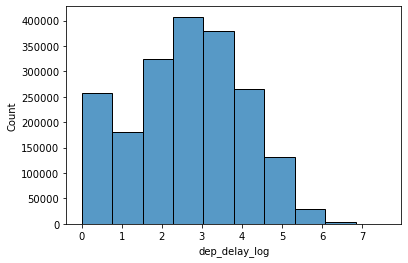

In [41]:
df_deep_delay = df.copy()
#Log transforming the departure delay variable. 
df_deep_delay['dep_delay_log'] = np.log(df['departure_delay']) 

#Distrbution of origin_airport variable.  
sns.histplot(df_deep_delay, x="dep_delay_log",bins=10); 

In [42]:
#creating a df for airlines and delay types 
airlinedelaytype = pd.DataFrame(df.groupby(['airline_name'])['air_system_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'].sum()).reset_index()

airlinedelaytype['total'] = airlinedelaytype['air_system_delay'] + airlinedelaytype['airline_delay'] + airlinedelaytype['late_aircraft_delay'] + airlinedelaytype['weather_delay'] 

airlinedelaytype['pcnt_late_aircraft_delay'] = (airlinedelaytype['late_aircraft_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_airline_delay'] = (airlinedelaytype['airline_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_air_system_delay'] = (airlinedelaytype['air_system_delay']/airlinedelaytype['total']) 

airlinedelaytype['pcnt_weather_delay'] = (airlinedelaytype['weather_delay']/airlinedelaytype['total']) 

#creating a df for months and delay types 
monthdelaytype = pd.DataFrame(df.groupby(['month'])['air_system_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay'].sum()).reset_index() 

monthdelaytype ['total'] = monthdelaytype ['air_system_delay'] + monthdelaytype['airline_delay'] + monthdelaytype['late_aircraft_delay'] + monthdelaytype['weather_delay'] 

monthdelaytype ['pcnt_late_aircraft_delay'] = (monthdelaytype ['late_aircraft_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_airline_delay'] = (monthdelaytype['airline_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_air_system_delay'] = (monthdelaytype ['air_system_delay']/monthdelaytype ['total']) 

monthdelaytype ['pcnt_weather_delay'] = (monthdelaytype ['weather_delay']/monthdelaytype ['total']) 

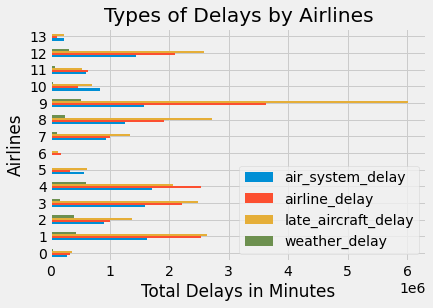

In [43]:
#plotting airlines against delay types 
airlinedelaytype1=airlinedelaytype[['airline_name','air_system_delay','airline_delay','late_aircraft_delay', 'weather_delay']].copy() 
plotdata=airlinedelaytype1 
mpl.style.use('fivethirtyeight')  
plotdata.plot(kind="barh") 
plt.title("Types of Delays by Airlines") 
plt.xlabel("Total Delays in Minutes") 
plt.ylabel("Airlines");

**Types of Delays by Airlines**: `Airline_delay` and `late_aircraft_delay` have the highest occurences from the types of delays. This makes sense as planes arriving late would contribute to an aircraft departing later than scheduled. Another area to explore would be to see the size of these delays as some airlines may be running magnatudes more than other airlines, giving them more opportunities to run into delays.

| # | Airline | Discussion |
| :--- | :--- | :--- |
|0| Alaska Airlines Inc. | Low delays across all categories |
|1| American Airlines Inc. | High delays across all categories |
|2| American Eagle Airlines Inc.| Moderate delays across all categories |
|3| Atlantic Southeast Airlines | High delays across all categories |
|4| Delta Air Lines Inc. | High delays across all categories |
|5|Frontier Airlines Inc. | Low delays across all categories |
|6| Hawaiian Airlines Inc.| Low delays across all categories |
|7| JetBlue Airways | Moderate delays across all categories |
|8| Skywest Airlines Inc. | High delays across all categories |
|9| Southwest Airlines Co. | High delays across all categories |
|10| Spirit Air Lines | Moderate delays across all categories |
|11| US Airways Inc | Moderate delays across all categories |
|12| United Air Lines Inc.| High delays across all categories |
|13| Virgin America | Low delays across all categories |

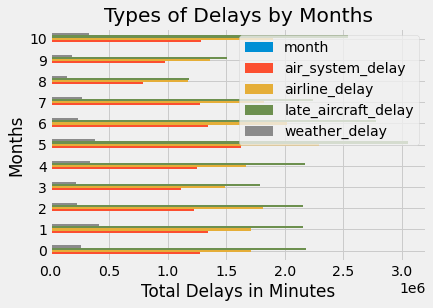

In [44]:
#Plotting Months Against Delay types 
monthdelaytype1=monthdelaytype[['month','air_system_delay','airline_delay','late_aircraft_delay', 'weather_delay']].copy() 
plotdata=monthdelaytype1 
mpl.style.use('fivethirtyeight')  
plotdata.plot(kind="barh") 
plt.title("Types of Delays by Months") 
plt.xlabel("Total Delays in Minutes") 
plt.ylabel("Months"); 

**Types of Delays by Month Chart** : By summing the total minutes for the types of delays per airline and per month we get similar trend in both charts where `late_aircraft_delay` and `airline_delay` have the largest total of delay minutes. We hypothesize that that system and mechanical issues are less likely to play influence flight delay than operating procedures. When we pair this with the most flights happen (starting at 5am) we theorize that once an airline is delayed, it will continue to try to play catch up throughout the day. This can be mitigated by plane speed but if standard operating procedures are not in place it is highly unlikely that an airline will get back on schedule. As the amount of flights decrease from 5a to 12a, this gives less opportunities for flights make up lost time which compounds the issue but could be an explanation why there are a lot of flights that have delays of less than 5 minutes.

| # | Month| Discussion |
| :--- | :--- | :--- |
| 0 | January | Moderate delays across all categories |
| 1 | February | Moderate delays across all categories |
| 2 | March | Moderate delays across all categories |
| 3 | April | Moderate delays across all categories |
| 4 | May | Moderate delays across all categories |
| 5 | June | High delays across all categories |
| 6 | July | High delays across all categories |
| 7 | August | High delays across all categories |
| 8 | September | Moderate delays across all categories |
| 9 | October | Moderate delays across all categories |
| 10 | November | Moderate delays across all categories |
| 11 | December | High delays across all categories |

#### Combination Plot to show Skewness of Data
> The below combination plot is used to determine look and feel of the skewness of delays across airlines. With the violin plot on the left, we are able to determine the majority of departures are well within a reasonable departure time, however each airline is severely right skewed and will have multiple outliers.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


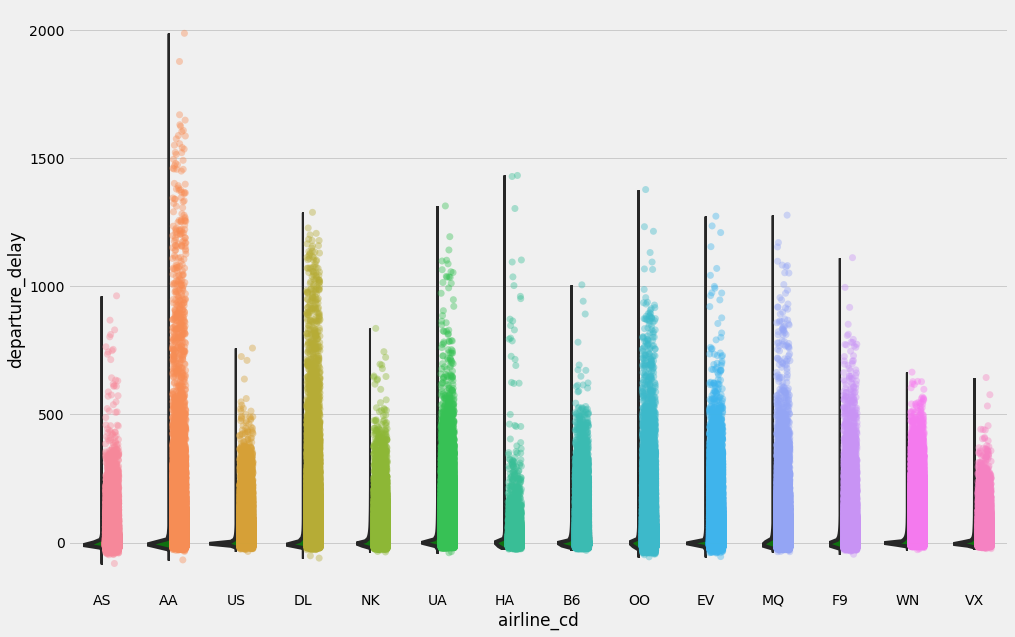

In [48]:
#adapted from online. Can't find website
plt.figure(figsize=(15, 10))
# Create violin plots without mini-boxplots inside.
ax = sns.violinplot(y='departure_delay',
                    x='airline_cd',
                    data=df,
                    color='green', 
                    cut=0,
                    inner=None)

# Clip the right half of each violin.
for item in ax.collections:
    x0, y0, width, height = item.get_paths()[0].get_extents().bounds
    item.set_clip_path(plt.Rectangle((x0, y0), width/2, height,
                       transform=ax.transData))

# Create strip plots with partially transparent points of different colors depending on the group.
num_items = len(ax.collections)
sns.stripplot(y='departure_delay',
              x='airline_cd',
              data=df,
              alpha=0.4,
              size=7)

# Shift each strip plot strictly below the correponding volin.
for item in ax.collections[num_items:]:
    item.set_offsets(item.get_offsets() + 0.15)


plt.legend(frameon=False, fontsize=15, loc='upper left');

#### Bar Chart of Average MPH per Airline

>We decided to explore a potential variable that could help mitigate an arrival delay, plane speed. The idea is that departure delay stops cumulating when the plane is in the air and arrival delays will start cumulating until the plane lands. Our assumption is each airline travels at a different speed due to factors like plane models, maintenance practices and weather. Since arrival time is redetermined, if a plane arrives early it is essentially mitigating minutes of delay by minimize `air_time` through plane speed. So it would be possible to have a departure delay but still arrive on time. 

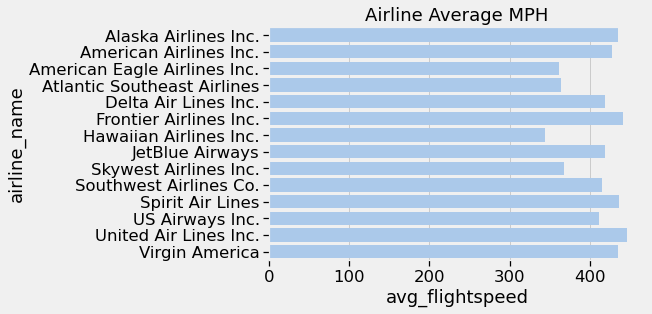

In [49]:
#establish airline flight speed

df_fs = df.copy()
df_fs['flightspeed'] = 60*df["distance"]/df["air_time"]

#setting airline mean speed 
airlinespeed = pd.DataFrame({'avg_flightspeed' : df_fs.groupby(['airline_name'])['flightspeed'].mean()}).reset_index() 
 
#Visualize average speed of each airline 
ax = sns.set_color_codes("pastel") 
sns.set_context("notebook", font_scale=1.5) 
ax = sns.barplot(x="avg_flightspeed", y="airline_name", data=airlinespeed, 
            label="accuracy", color="b").set(title='Airline Average MPH') 

***

## Preprocessing
> Because we want to predict if an airplane is going to be delayed or not using classification models, we created a new field called `is_delay` from the `departure_delay` field. To do this, we created a function that we could pass a numeric field through and if the value for that row is greater than 0, we imputed "1" into the curated field to signifiy the flight was delayed. If the value was less than 0, we imputed "0" to signify that the flight was not delayed. 

> After creating the `is_delay` field, we then began to One Hot Encode any categorial variables so that our model could interpret and use those columns. This caused a 250k by 42 data set to become 240k by 3400.

> All fields with data types that are not integer or float will be removed as they are One Hot Encoded.
***

In [8]:
df = pd.read_csv(r"C:\Users\Alex M\Downloads\airline_merged.csv",low_memory=False)

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
#removing unwanted column from previous export
df = df.drop(columns =['Unnamed: 0'],axis =1)

In [11]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

In [12]:
#selecting subset of data set
airports = ['BHM']

In [13]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [14]:
df_air.describe()

year         month           day   day_of_week  flight_number  \
count  12514.0  12514.000000  12514.000000  12514.000000   12514.000000   
mean    2015.0      6.150951     15.687710      3.879575    2876.476346   
std        0.0      3.384375      8.763785      1.992624    1951.952017   
min     2015.0      1.000000      1.000000      1.000000       3.000000   
25%     2015.0      3.000000      8.000000      2.000000    1051.000000   
50%     2015.0      6.000000     16.000000      4.000000    2525.000000   
75%     2015.0      9.000000     23.000000      5.000000    4592.000000   
max     2015.0     12.000000     31.000000      7.000000    6813.000000   

       latitude_origin  latitude_destination  scheduled_departure  \
count              0.0                   0.0         12514.000000   
mean               NaN                   NaN          1192.116909   
std                NaN                   NaN           445.126945   
min                NaN                   NaN           500.000000   
25%                NaN                   NaN           745.000000   
50%                NaN                   NaN          1200.000000   
75%                NaN                   NaN          1609.000000   
max                NaN                   NaN          2055.000000   

       departure_delay      taxi_out  scheduled_time     wheels_on  \
count     12338.000000  12334.000000    12514.000000  12324.000000   
mean          9.032906     13.783525      108.121864   1399.118306   
std          43.869223      7.389709       36.974468    458.707388   
min         -20.000000      4.000000       52.000000      3.000000   
25%          -5.000000      9.000000       76.000000    952.000000   
50%          -2.000000     12.000000      113.000000   1402.000000   
75%           4.000000     16.000000      123.000000   1823.000000   
max        1988.000000    116.000000      260.000000   2357.000000   

            taxi_in  scheduled_arrival      diverted     cancelled  \
count  12324.000000       12514.000000  12514.000000  12514.000000   
mean       8.632587        1416.011507      0.004075      0.014464   
std        5.844535         443.946518      0.063711      0.119397   
min        1.000000         707.000000      0.000000      0.000000   
25%        5.000000        1009.000000      0.000000      0.000000   
50%        7.000000        1414.000000      0.000000      0.000000   
75%       10.000000        1825.000000      0.000000      0.000000   
max      150.000000        2325.000000      1.000000      1.000000   

       air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
count       2128.000000     2128.000000    2128.000000          2128.000000   
mean          14.805921        0.091635      20.292293            27.732613   
std           32.820428        3.167858      73.036267            47.048389   
min            0.000000        0.000000       0.000000             0.000000   
25%            0.000000        0.000000       0.000000             0.000000   
50%            3.000000        0.000000       0.000000             9.000000   
75%           18.000000        0.000000      10.000000            34.000000   
max          493.000000      144.000000    1971.000000           420.000000   

       weather_delay  
count    2128.000000  
mean        2.580827  
std        16.190917  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max       240.000000

In [15]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

In [16]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

In [17]:
df_air.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  12514 non-null  int64  
 1   month                 12514 non-null  int64  
 2   day                   12514 non-null  int64  
 3   day_of_week           12514 non-null  int64  
 4   airline_cd            12514 non-null  object 
 5   airline_name          12514 non-null  object 
 6   flight_number         12514 non-null  int64  
 7   tail_number           12510 non-null  object 
 8   origin_airport        12514 non-null  object 
 9   airport_origin        12514 non-null  object 
 10  city_origin           12514 non-null  object 
 11  state_origin          12514 non-null  object 
 12  country_origin        12514 non-null  object 
 13  latitude_origin       0 non-null      float64
 14  destination_airport   12514 non-null  object 
 15  airport_destina

In [18]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='error',drop='first')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [19]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

Final data set after One Hot Encoding is 12,514 x 1,777. Below is a condensed view of the data set as 1,777 columns is too long to print.

In [20]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Columns: 1775 entries, year to 1752
dtypes: float64(1765), int64(10)
memory usage: 169.8 MB


In [21]:
#Specififying Stratified Kfold for cv.

from sklearn.model_selection import StratifiedKFold

skfcv = StratifiedKFold(n_splits=10)

### Random Forest Grid Search
>used to aquire feature used in a below model

#Task 1 Grid Search parameters: 
#Specifying the number of trees in random forest:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
#Specifying criterion for each split:
criterion = ['gini','entropy']
#Specifying the number of features to consider at every split:
max_features = ['auto','sqrt', 'log2','none']

#Creating pipeline for GridSearch:
#Creating and printing my random grid with parameters defined above:
param_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features}
print(param_grid)

#Base RF model used to tune:
rf = RandomForestClassifier(random_state=0)

#Throwing RF through a GridSearch:
rf_random = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=1)

%%time
#Fiting the random search model on our training data:
rf_random.fit(X_delay_train, y_delay_train)

#Viewing the best parameters selected from GridSearch:
rf_random.best_params_

### Re-Fitting Random Forest with GridSearch Parameters

#Defining RF model with best parameters from GridSearch:
rf_gs = RandomForestClassifier(criterion='entropy',max_features='auto',n_estimators=100,random_state=0) #INSERT IN BEST GRIDSEARCH PARAMS

#Re-fitting RF model with GS parameters and SKFCV on training data:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score_train = cross_val_score(rf_gs, X_delay_train, y_delay_train, cv=skfcv, scoring='accuracy')

rf_gs.fit(X_delay_train,y_delay_train)
rf_gs_pred = rf_gs.predict(X_delay_test)

#Viewing performance metrics:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, rf_gs_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, rf_gs_pred))
print("=== All AUC Scores ===")
print(rfc_cv_score_train)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest (Delay): ", rfc_cv_score_train.mean())

### Feature Importances for GridSearch RF Model

importances = rf_gs.feature_importances_

# Getting indices of N = 3 maximum values
x = np.argsort(importances)[::-1][:5]
print("Indices:",x)

# Getting N maximum values
print("Values:",importances[x])

plt.title('RF Train Data Feature Importances')
(pd.Series(rf_gs.feature_importances_, index=X_delay_test.columns)
   .nlargest(5)
   .plot(kind='barh')) ;

### Visualizing task one RF GridSearch Model

#ROC Curve
rf_delay_ypred_proba = rf_gs.predict_proba(X_delay_test)[::,1]
fpr_rf_delay, tpr_rf_delay, _ = metrics.roc_curve(y_delay_test,  rf_delay_ypred_proba)
rf_delay_auc = metrics.roc_auc_score(y_delay_test, rf_delay_ypred_proba)
plt.plot(fpr_rf_delay,tpr_rf_delay,label="RF with CV: Delay, auc= "+str(round(rf_delay_auc,5)))
plt.legend(loc=0)
plt.show();

# Modeling and Evaluation 1
## Train and adjust parameters

### Agglomerative Clustering on RF features:

In [22]:
AG = final_df[["wheels_on","day","taxi_out","taxi_in"]]
AG.head()

wheels_on  day  taxi_out  taxi_in
321       846.0    1      19.0      6.0
730       823.0    1       9.0      5.0
734       839.0    1      12.0     16.0
2191     1035.0    1      16.0     11.0
2303     1125.0    1      11.0      5.0

In [23]:
AG.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wheels_on  12324 non-null  float64
 1   day        12514 non-null  int64  
 2   taxi_out   12334 non-null  float64
 3   taxi_in    12324 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 746.9 KB


In [34]:
#Imputing null and infinity values. 
print(np.any(np.isnan(AG)))
AG_clean = np.nan_to_num(AG)

True


In [36]:
#Normalizing data. 
from sklearn.preprocessing import normalize
data_scaled = normalize(AG_clean)

In [37]:
#Conferting array to a DF. 
d2 = pd.DataFrame(data_scaled, columns = ['wheels_on','day','taxi_out','taxi_in'])
d2.head()

wheels_on       day  taxi_out   taxi_in
0   0.999722  0.001182  0.022452  0.007090
1   0.999921  0.001215  0.010935  0.006075
2   0.999715  0.001192  0.014299  0.019065
3   0.999824  0.000966  0.015456  0.010626
4   0.999942  0.000889  0.009777  0.004444

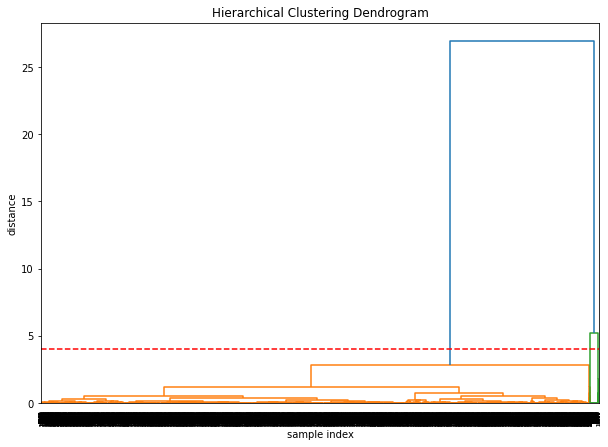

In [26]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Hierarchical Clustering Dendrogram")  
plt.xlabel('sample index')
plt.ylabel('distance')

dend = shc.dendrogram(shc.linkage(d2, method='ward'))
plt.axhline(y=4, color='r', linestyle='--')
plt.show()

In [64]:
#Importing Allogmerative Clustering library and creating a pipeline. 

from sklearn.cluster import AgglomerativeClustering
clusteragrf = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
clusteragrf.fit(d2)

AgglomerativeClustering(n_clusters=3)

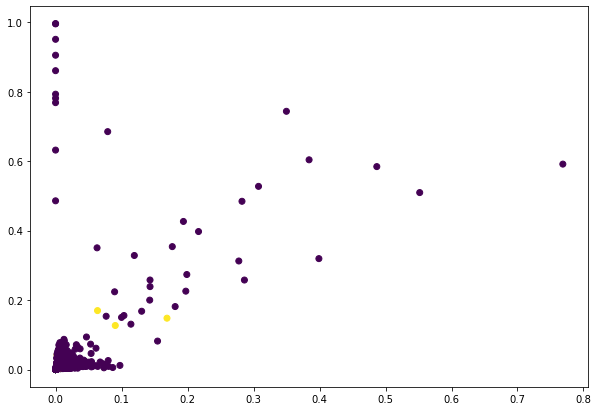

In [65]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(d2['taxi_in'], d2['taxi_out'], c=cluster.labels_)

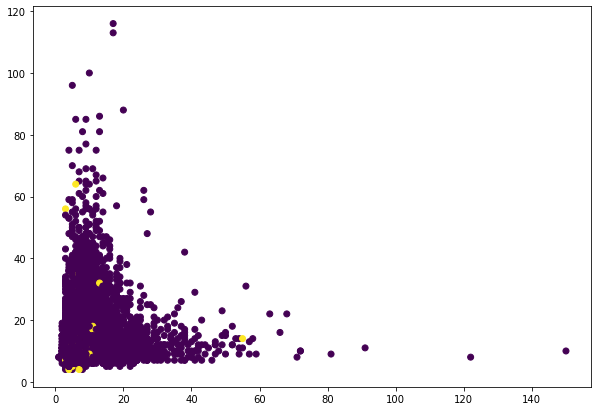

In [66]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(AG['taxi_in'], AG['taxi_out'], c=cluster.labels_)

In [67]:
#Calculating silhouette score:
from sklearn.metrics import silhouette_score

silhouette_score(d2,clusteragrf.labels_)

0.985507140241268

In [68]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(d2,clusteragrf.labels_)

0.44981191490914313

### Agglomerative Clustering On Delayed Columns:

In [42]:
AG2 = final_df.loc[:,["air_system_delay","security_delay","airline_delay","late_aircraft_delay","weather_delay"]]
AG2.head()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
321                NaN             NaN            NaN                  NaN   
730                NaN             NaN            NaN                  NaN   
734                NaN             NaN            NaN                  NaN   
2191               NaN             NaN            NaN                  NaN   
2303               NaN             NaN            NaN                  NaN   

      weather_delay  
321             NaN  
730             NaN  
734             NaN  
2191            NaN  
2303            NaN

In [43]:
#Viewing summary stats from AG2 DF. 
AG2.describe()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
count       2128.000000     2128.000000    2128.000000          2128.000000   
mean          14.805921        0.091635      20.292293            27.732613   
std           32.820428        3.167858      73.036267            47.048389   
min            0.000000        0.000000       0.000000             0.000000   
25%            0.000000        0.000000       0.000000             0.000000   
50%            3.000000        0.000000       0.000000             9.000000   
75%           18.000000        0.000000      10.000000            34.000000   
max          493.000000      144.000000    1971.000000           420.000000   

       weather_delay  
count    2128.000000  
mean        2.580827  
std        16.190917  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max       240.000000

In [44]:
#Summing null values in AG2 DF:
print('Nulls in air_system_delay =', AG2['air_system_delay'].isna().sum())
print('Nulls in security_delay =', AG2['security_delay'].isna().sum())
print('Nulls in airline_delay =', AG2['airline_delay'].isna().sum())
print('Nulls in late_aircraft__delay =', AG2['late_aircraft_delay'].isna().sum())
print('Nulls in weather_delay =', AG2['weather_delay'].isna().sum())

Nulls in air_system_delay = 10386
Nulls in security_delay = 10386
Nulls in airline_delay = 10386
Nulls in late_aircraft__delay = 10386
Nulls in weather_delay = 10386


In [45]:
#Imputing Nulls with 0's:
AG2['air_system_delay'] = AG2['air_system_delay'].fillna(0)
AG2['security_delay'] = AG2['security_delay'].fillna(0)
AG2['airline_delay'] = AG2['airline_delay'].fillna(0)
AG2['late_aircraft_delay'] = AG2['late_aircraft_delay'].fillna(0)
AG2['weather_delay'] = AG2['weather_delay'].fillna(0)

In [46]:
#Verifying nulls have been removed from AG2:
print('Nulls in air_system_delay =', AG2['air_system_delay'].isna().sum())
print('Nulls in security_delay =', AG2['security_delay'].isna().sum())
print('Nulls in airline_delay =', AG2['airline_delay'].isna().sum())
print('Nulls in late_aircraft__delay =', AG2['late_aircraft_delay'].isna().sum())
print('Nulls in weather_delay =', AG2['weather_delay'].isna().sum())

Nulls in air_system_delay = 0
Nulls in security_delay = 0
Nulls in airline_delay = 0
Nulls in late_aircraft__delay = 0
Nulls in weather_delay = 0


In [47]:
#Viewing AG2 DF to verify no more nulls exist:
AG2.head()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
321                0.0             0.0            0.0                  0.0   
730                0.0             0.0            0.0                  0.0   
734                0.0             0.0            0.0                  0.0   
2191               0.0             0.0            0.0                  0.0   
2303               0.0             0.0            0.0                  0.0   

      weather_delay  
321             0.0  
730             0.0  
734             0.0  
2191            0.0  
2303            0.0

In [48]:
#Normalizing AG2: NOTE THIS DOES NOT CLUSTER AS WELL.
from sklearn.preprocessing import normalize
data_scaled3 = normalize(AG2)

In [49]:
#Converting normalized array to a DF:
delay_norm = pd.DataFrame(data_scaled3, columns = ['air_system_delay','security_delay','airline_delay','late_aircraft_delay','weather_delay'])
delay_norm.head()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
0               0.0             0.0            0.0                  0.0   
1               0.0             0.0            0.0                  0.0   
2               0.0             0.0            0.0                  0.0   
3               0.0             0.0            0.0                  0.0   
4               0.0             0.0            0.0                  0.0   

   weather_delay  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [50]:
#Viewing summary stats from normalized data:
delay_norm.describe()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
count      12514.000000    12514.000000   12514.000000         12514.000000   
mean           0.061370        0.000354       0.042717             0.080687   
std            0.222613        0.017237       0.183897             0.261211   
min            0.000000        0.000000       0.000000             0.000000   
25%            0.000000        0.000000       0.000000             0.000000   
50%            0.000000        0.000000       0.000000             0.000000   
75%            0.000000        0.000000       0.000000             0.000000   
max            1.000000        1.000000       1.000000             1.000000   

       weather_delay  
count   12514.000000  
mean        0.006942  
std         0.077518  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

RecursionError: maximum recursion depth exceeded while getting the str of an object

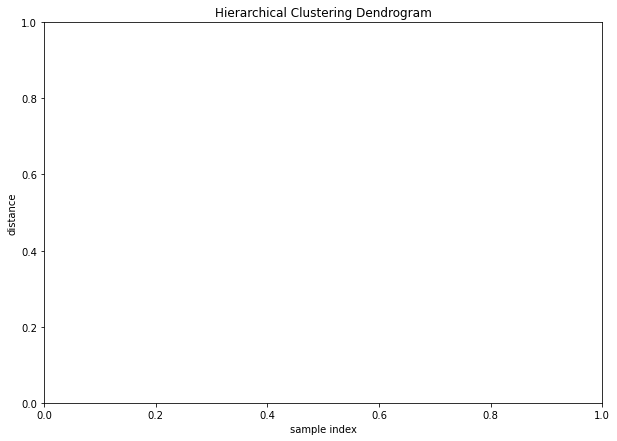

In [52]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Hierarchical Clustering Dendrogram")  
plt.xlabel('sample index')
plt.ylabel('distance')

dend = shc.dendrogram(shc.linkage(AG2, method='ward'))
plt.show()

In [69]:
#Importing Allogmerative Clustering library and creating a pipeline. 

from sklearn.cluster import AgglomerativeClustering
clusteragd = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
clusteragd.fit(AG2)

AgglomerativeClustering()

In [ ]:
predictagd = clusteragd.fit_predict(AG2)

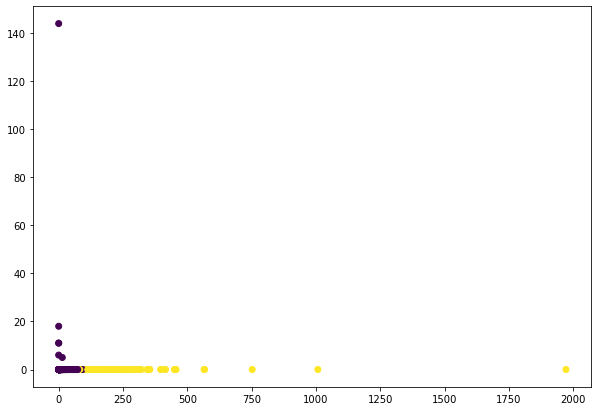

In [54]:
#Visualizing aggglomerative clustering output:
plt.figure(figsize=(10, 7))  
plt.scatter(AG2['airline_delay'], AG2['security_delay'], c=cluster.labels_)

In [70]:
#Calculating silhouette score:
#from sklearn.metrics import silhouette_score

silhouette_score(AG2,clusteragd.labels_)

0.9262887090338827

In [71]:
#from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(AG2,clusteragd.labels_)

0.5586958956215278

### DBSCAN Clustering On Delayed Columns:

In [72]:
AG2 = final_df.loc[:,["air_system_delay","security_delay","airline_delay","late_aircraft_delay","weather_delay"]]
AG2.head()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
321                NaN             NaN            NaN                  NaN   
730                NaN             NaN            NaN                  NaN   
734                NaN             NaN            NaN                  NaN   
2191               NaN             NaN            NaN                  NaN   
2303               NaN             NaN            NaN                  NaN   

      weather_delay  
321             NaN  
730             NaN  
734             NaN  
2191            NaN  
2303            NaN

In [73]:
#Viewing summary stats from AG2 DF. 
AG2.describe()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
count       2128.000000     2128.000000    2128.000000          2128.000000   
mean          14.805921        0.091635      20.292293            27.732613   
std           32.820428        3.167858      73.036267            47.048389   
min            0.000000        0.000000       0.000000             0.000000   
25%            0.000000        0.000000       0.000000             0.000000   
50%            3.000000        0.000000       0.000000             9.000000   
75%           18.000000        0.000000      10.000000            34.000000   
max          493.000000      144.000000    1971.000000           420.000000   

       weather_delay  
count    2128.000000  
mean        2.580827  
std        16.190917  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max       240.000000

In [74]:
#Summing null values in AG2 DF:
print('Nulls in air_system_delay =', AG2['air_system_delay'].isna().sum())
print('Nulls in security_delay =', AG2['security_delay'].isna().sum())
print('Nulls in airline_delay =', AG2['airline_delay'].isna().sum())
print('Nulls in late_aircraft__delay =', AG2['late_aircraft_delay'].isna().sum())
print('Nulls in weather_delay =', AG2['weather_delay'].isna().sum())

Nulls in air_system_delay = 10386
Nulls in security_delay = 10386
Nulls in airline_delay = 10386
Nulls in late_aircraft__delay = 10386
Nulls in weather_delay = 10386


In [75]:
#Imputing Nulls with 0's:
AG2['air_system_delay'] = AG2['air_system_delay'].fillna(0)
AG2['security_delay'] = AG2['security_delay'].fillna(0)
AG2['airline_delay'] = AG2['airline_delay'].fillna(0)
AG2['late_aircraft_delay'] = AG2['late_aircraft_delay'].fillna(0)
AG2['weather_delay'] = AG2['weather_delay'].fillna(0)

In [76]:
#Verifying nulls have been removed from AG2:
print('Nulls in air_system_delay =', AG2['air_system_delay'].isna().sum())
print('Nulls in security_delay =', AG2['security_delay'].isna().sum())
print('Nulls in airline_delay =', AG2['airline_delay'].isna().sum())
print('Nulls in late_aircraft__delay =', AG2['late_aircraft_delay'].isna().sum())
print('Nulls in weather_delay =', AG2['weather_delay'].isna().sum())

Nulls in air_system_delay = 0
Nulls in security_delay = 0
Nulls in airline_delay = 0
Nulls in late_aircraft__delay = 0
Nulls in weather_delay = 0


In [77]:
#Viewing AG2 DF to verify no more nulls exist:
AG2.head()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
321                0.0             0.0            0.0                  0.0   
730                0.0             0.0            0.0                  0.0   
734                0.0             0.0            0.0                  0.0   
2191               0.0             0.0            0.0                  0.0   
2303               0.0             0.0            0.0                  0.0   

      weather_delay  
321             0.0  
730             0.0  
734             0.0  
2191            0.0  
2303            0.0

In [78]:
from sklearn.cluster import DBSCAN
clustedb = DBSCAN(eps=0.125, min_samples=6)
clustedb.fit(AG2)
dbs_labels = clustedb.labels_ 

In [79]:
#Calculating silhouette score:
#from sklearn.metrics import silhouette_score

silhouette_score(AG2,dbs_labels)

0.7803617418437745

In [80]:
#from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(AG2,dbs_labels)

1.811938519864813

In [ ]:
predictdb = clustedb.fit_predict(AG2)

### KMeans Clustering On Delayed Columns:

In [81]:
AG2 = final_df.loc[:,["air_system_delay","security_delay","airline_delay","late_aircraft_delay","weather_delay"]]
AG2.head()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
321                NaN             NaN            NaN                  NaN   
730                NaN             NaN            NaN                  NaN   
734                NaN             NaN            NaN                  NaN   
2191               NaN             NaN            NaN                  NaN   
2303               NaN             NaN            NaN                  NaN   

      weather_delay  
321             NaN  
730             NaN  
734             NaN  
2191            NaN  
2303            NaN

In [82]:
#Viewing summary stats from AG2 DF. 
AG2.describe()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
count       2128.000000     2128.000000    2128.000000          2128.000000   
mean          14.805921        0.091635      20.292293            27.732613   
std           32.820428        3.167858      73.036267            47.048389   
min            0.000000        0.000000       0.000000             0.000000   
25%            0.000000        0.000000       0.000000             0.000000   
50%            3.000000        0.000000       0.000000             9.000000   
75%           18.000000        0.000000      10.000000            34.000000   
max          493.000000      144.000000    1971.000000           420.000000   

       weather_delay  
count    2128.000000  
mean        2.580827  
std        16.190917  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max       240.000000

In [83]:
#Summing null values in AG2 DF:
print('Nulls in air_system_delay =', AG2['air_system_delay'].isna().sum())
print('Nulls in security_delay =', AG2['security_delay'].isna().sum())
print('Nulls in airline_delay =', AG2['airline_delay'].isna().sum())
print('Nulls in late_aircraft__delay =', AG2['late_aircraft_delay'].isna().sum())
print('Nulls in weather_delay =', AG2['weather_delay'].isna().sum())

Nulls in air_system_delay = 10386
Nulls in security_delay = 10386
Nulls in airline_delay = 10386
Nulls in late_aircraft__delay = 10386
Nulls in weather_delay = 10386


In [84]:
#Imputing Nulls with 0's:
AG2['air_system_delay'] = AG2['air_system_delay'].fillna(0)
AG2['security_delay'] = AG2['security_delay'].fillna(0)
AG2['airline_delay'] = AG2['airline_delay'].fillna(0)
AG2['late_aircraft_delay'] = AG2['late_aircraft_delay'].fillna(0)
AG2['weather_delay'] = AG2['weather_delay'].fillna(0)

In [85]:
#Verifying nulls have been removed from AG2:
print('Nulls in air_system_delay =', AG2['air_system_delay'].isna().sum())
print('Nulls in security_delay =', AG2['security_delay'].isna().sum())
print('Nulls in airline_delay =', AG2['airline_delay'].isna().sum())
print('Nulls in late_aircraft__delay =', AG2['late_aircraft_delay'].isna().sum())
print('Nulls in weather_delay =', AG2['weather_delay'].isna().sum())

Nulls in air_system_delay = 0
Nulls in security_delay = 0
Nulls in airline_delay = 0
Nulls in late_aircraft__delay = 0
Nulls in weather_delay = 0


In [86]:
#Viewing AG2 DF to verify no more nulls exist:
AG2.head()

air_system_delay  security_delay  airline_delay  late_aircraft_delay  \
321                0.0             0.0            0.0                  0.0   
730                0.0             0.0            0.0                  0.0   
734                0.0             0.0            0.0                  0.0   
2191               0.0             0.0            0.0                  0.0   
2303               0.0             0.0            0.0                  0.0   

      weather_delay  
321             0.0  
730             0.0  
734             0.0  
2191            0.0  
2303            0.0

In [87]:
from sklearn.cluster import KMeans
clusterkm = KMeans(n_clusters=17, random_state=0)
clusterkm.fit(AG2)
kmn_labels = clusterkm.labels_

In [89]:
#Calculating silhouette score:
#from sklearn.metrics import silhouette_score

silhouette_score(AG2,kmn_labels)

0.8779625819427967

In [90]:
#from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(AG2,kmn_labels)

0.561111141104278

In [ ]:
predictkm = clusterkm.fit_predict( )

TypeError: '(slice(None, None, None), 0)' is an invalid key

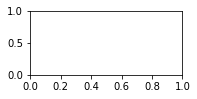

In [63]:
for i,l in enumerate([dbs_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(AG2[:, 0], data[:, 1]+np.random.random(AG2[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Taxi_out'), plt.ylabel('INSERT LABEL')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(AG2[:, 0], AG2[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Taxi_out'), plt.ylabel('INSERT LABEL')
    plt.grid()
    plt.title(title[i])

# Modeling and Evaluation 2

### Evaluate and Compare

In [ ]:
from sklearn.metrics.cluster import rand_score

rand_score(clusteragrfr.labels_,predictagrf)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(clusteragrf.labels_,predictagrf)

In [ ]:
from sklearn.metrics.cluster import v_measure_score

v_measure_score(clusteragrfr.labels_,predictagrf)

# Modeling and Evaluation 3

### Visualize Results

# Modeling and Evaluation 4

### Summarize the Ramifications

# Deployment

# Exceptional Work